# ModelFlow features

This notebook demonstrates a number of the reporting features of the modelflow object developed by Ib Hansen and housed on GitHun at https://github.com/IbHansen.   

This overview is a joint effort of Ib Hansen and Andrew Burns.



## Import the model class
This class incorporates most of the methods used to manage a model.  Assuming the ModelFlow class has been installed on your machine, the following cells set up your notebook for the eb=nvironment.

In [1]:
 %load_ext autoreload
 %autoreload 2

In [2]:
from ipywidgets import interact,Dropdown,Checkbox
from IPython.display import display    # , clear_output

from modelclass import model 
import modeljupyter as mj
model.widescreen()
model.scroll_off()

## Load an already existing model and associated data

Create a model instance mpak and a results dataframe using the modelload method and a pre-existing macroeconomic model of Pakistan.

In [3]:
mpak,result = model.modelload('pak.pcim',run=1,silent=1)

The file `pak.pcim` contains a dump of model equations, dataframe, simulation options and variable descriptions. The creation of this model, is the subject of another notebook.  

The modelload method processes the file and initiates the mpak model with both equations and teh data incldued in the pak.pcim file.

mpak is the particular instanitation of the  model object with which we will work.

result is a dataframe the dataframe containing the data that was loaded. This data is also exists inside the model object mpak.

mpak.latestdf which points to the same dataframe
mpak.basedf points to the baseline dataframe.  

Following a load these two (three if we include result) all have the same data

Finally we set the global smpl period to 1980 through 2100

In [4]:

result = result.fillna(0.0)
mpak.smpl(1980,2100)

Int64Index([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
            ...
            2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100],
           dtype='int64', length=121)

## Set the system up to do some simulations

Create a glossary of variable descriptions for some mnemonics we are interested in 

In [5]:
des = '''\
Real GDP: PAKNYGDPMKTPKN
Real Consumption: PAKNECONPRVTKN
Real Investment: PAKNEGDIFTOTKN
Real Exports: PAKNEEXPGNFSKN
Real Imports: PAKNEIMPGNFSKN
Unemployment rate: PAKLMUNRTOTLCN
Debt (%GDP): PAKGGDBTTOTLCN_
Total emissions from fossil fuels: PAKCCEMISCO2TKN
Fiscal revenues: PAKGGREVTOTLCN
Working days lost due to pollution: PAKWDL'''
desdict = {line.split(':')[1].strip() : line.split(':')[0] for line in des.split('\n')}
mpak.set_var_description(desdict)
desvar = ' '.join(desdict.keys())

### Make a new dataframe containing data /variables that we want to exogenize 

In the simulations below we want all of the government expenditure variables to be held constant (unchanged nominal policies).

First we create an array of variables that we want to exogenize.
Then we create two new lists exovalues and dummies with the same names but _C and _D appended to them 

<p>
<div class="warning" style='padding:0.1em; background-color:#E9D8FD; color:#69337A'>

<p style='margin-top:1em; text-align:center'>
<b>Box:Exogenizing Endogenous variables</b></p>
<p style='margin-left:1em;'>

In WB models using modelflow each endogenous equation is written in the following form


    y=(f(stuff +y_AF)*(1-y_D)+y_D*y_X


Thus there are three variables in the model for each endogenous variable
  
    y   : the variable itself
    y_D : a dummy variable set to 1 when the equation has been exogenized
    y_X : a variable that represents the exogenized value that the equation should resolve to if exogenized
    y_AF: An add factor used to shift the result of an eqyation by a specific amount.
    
Thus if D=0 (the equation i turned on), the model will resolve to

    y=f(stuff)+y_X

if D=1 then the equation has been exogenized (turned off) and it will resolve to:

    y=y_X

<p style='margin-top:1em; text-align:center'>
<b>End of Box</b></p>    

</div>


In [6]:
var_to_be_exogenized = 'PAKGGEXPCAPTCN PAKGGEXPGNFSCN PAKGGEXPOTHRCN PAKGGEXPTRNSCN'.split() #Array of mnemonics of the government expenditure variables that we want to keep constant

#This is the equivalent of wcross(vars+to_be_exogenized,"_X") in Eviews
exovalues   = [f'{v}_X' for v in var_to_be_exogenized] #loops across var_to_be_exogenized and creates an array of variable  neams with _X appended
dummies     = [f'{v}_D' for v in var_to_be_exogenized] #loops across var_to_be_exogenized and creates an array of variable  neams with _D appended

#Create new dataframe exostart as a copy of the basebline dataframe
exostart = result.copy()

#loops through each item in v,e,d and 
# 1) sets the e variables in (exovalues) equal to the actual
# 1) sets the d variables in (dummies) equal to 1

#Equibvalent to model.exclude and model.override in Eviews
# and setting the _2 variable to the value of the _0

for v,e,d  in zip(var_to_be_exogenized,exovalues,dummies):
    exostart.loc[:,e] = result.loc[:,v]
    exostart.loc[:,d] = 1

    

### Set up a simulation of a 29USD Carbon tax

As modelled the carbon tax is nominal (which for non-negative inflation means the carbon tax will be declining in real terms).

First we will clear any existing kept solutions that may linger from earlier work.
Next generate a new baseline using the values in the exostartdatafera,e which was a copy of the original but with selected variables having been exogenized ( _D=1) and specific values set _X = the orginal values. 

The dictionary experiments is created to provide some easier to read labels for the carbon taxes being imposed on each of Coal, Oil and Gas.

A uniform carbon tax of 29$ is set.

We duplicate the dataframe ised for the baseline (exostart)

And then modify the value of the three carbon taxes by setting them equal to 29.  As the tax rate variables are exoegnous to begin with there ie no need to do anything other than set them equal to zero.

Finally we solve the model, assigning the results to the res2 dataframe.


In [7]:
#Clear the list of kept solutions
mpak.keep_solutions ={}    

mpak.smpl(2010,2100)
#run a solution using the revised model and replacing the dataframe with the new one (exostart)  (that includes the exogenized variables) with their values.  Store thre results in a dataframecalled Baseline
# they will also be stored in mpak.latestdf

_ = mpak(exostart,alfa = 1,silent=1,keep=f'Baseline') # - is just a variable name - like soing a first solve and now storing _0 to 
mpak.basedf = _.copy() 

experiments = {'Carbon tax on Coal (USD/Ton)':'PAKGGREVCO2CER',
               'Carbon tax on Oil (USD/Ton' :'PAKGGREVCO2OER',
               'Carbon tax on Natural Gas (USD/Ton' :'PAKGGREVCO2GER'}
value = 29

alternative_exo = exostart.copy() #makes a copy of the dataset

for tax,var in experiments.items():
        alternative_exo.loc[2020:2100,var] = value  # sets the carbon tax on all three products to value (29)
        
        
res= mpak(alternative_exo,2020,2100,alfa = 0.7,silent=1,solver = 'sim',relconv = 0.00000001,
         keep=f'Coal, Oil and Gastax : {value} exogenized') #runs the solutiona nd saves it with the name to teh left

# Reporting Results

Thats it we have loaded the model, designed a simulation and solved the model.  The rest of this notebook exploresd ways to get data out of the model object that we have created and teh scenario we have run.

## Set the global sample period


In [8]:
mpak.smpl(2020,2023)  
# Now the global smpl is set, take care when running cells above 
# i.e. oui may need to reset smpl if you go backwards uin a Jupyter notebook world)

Int64Index([2020, 2021, 2022, 2023], dtype='int64')

 ## Displaying the values of variables
 
 If we pass mnemonics to the model obkect we will get the value of the variable(s) for the time periods set in the global sample. By default the values are from the latest solution.

In [9]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'] # get the last dataframe values  

      PAKNYGDPMKTPKN  PAKNECONPRVTKN
2020    2.490082e+07    2.202346e+07
2021    2.428466e+07    2.238858e+07
2022    2.412053e+07    2.293297e+07
2023    2.431639e+07    2.359251e+07

We can also use wildcards (*,?) to get the value of all matching vars.  Here *NYGDPMKTP?N returns all variables that contain the letters NYGDPMKTP followed by at one other letter and then an N.  In this case: PAKNYGDPMKTPCN  PAKNYGDPMKTPKN  PAKNYGDPMKTPXN.

PAKNECONPRVT?N is simpler it returns all variables that begin PAKNECONPRVT have one letter and end with N, in this case three  variables match these criteria: PAKNECONPRVTCN  PAKNECONPRVTKN  PAKNECONPRVTXN.


In [10]:
mpak['*NYGDPMKTP?N PAKNECONPRVT?N'] # Pattern can also be used * and ? are legag wildcards. 

      PAKNYGDPMKTPCN  PAKNYGDPMKTPKN  PAKNYGDPMKTPXN  PAKNECONPRVTCN  PAKNECONPRVTKN  PAKNECONPRVTXN
2020    4.011131e+07    2.490082e+07        1.610843    3.393983e+07    2.202346e+07        1.541076
2021    4.176230e+07    2.428466e+07        1.719699    3.636838e+07    2.238858e+07        1.624417
2022    4.340347e+07    2.412053e+07        1.799441    3.862295e+07    2.293297e+07        1.684167
2023    4.475014e+07    2.431639e+07        1.840328    4.038977e+07    2.359251e+07        1.711974

If you want to look at some data from outside the current time period. you can use the dataframe and the .loc syntax. But note that this is using the dataframe 'res; where the results were placed, not the model object: 'mpak'. 

In [11]:
res.loc['2016':'2022','PAKNYGDPMKTPKN']  # This is jst standard python no model object, using the dataframe created when we solved the model

2016    2.284690e+07
2017    2.411588e+07
2018    2.552339e+07
2019    2.577577e+07
2020    2.490082e+07
2021    2.428466e+07
2022    2.412053e+07
Name: PAKNYGDPMKTPKN, dtype: float64

We can get the same result using the with and set_smpl commands, but this time extracting the data vfrom the model object 'mpak'. 

Unlike mpak.smpl(2020,2025), the with syntax changes the smpl only for the period the indented commands that follow


In [12]:
with mpak.set_smpl(2016,2022):
    print(mpak['PAKNYGDPMKTPKN'])  # this time I am using the data from inside the model object.

      PAKNYGDPMKTPKN
2016    2.284690e+07
2017    2.411588e+07
2018    2.552339e+07
2019    2.577577e+07
2020    2.490082e+07
2021    2.428466e+07
2022    2.412053e+07



### Similarily you can specify which of the dataframe to take the data from

By default you are seeing the results of the latest simulation.  But you can also specify which of the kpet solutions yo take the data from.




In [13]:
kept=mpak.keep_solutions #create a dataframe from the model object kept objects
kept.keys() # lists the names of the scenarios



dict_keys(['Baseline', 'Coal, Oil and Gastax : 29 exogenized'])

Because these results are coming from the dataframe (not the model object) the global sample has no impact.  The above (and below) is just straight up python pandas.

In [14]:
kept['Coal, Oil and Gastax : 29 exogenized']['PAKNYGDPMKTPKN']

1980    4.354491e+06
1981    4.699399e+06
1982    5.006622e+06
1983    5.345990e+06
1984    5.616775e+06
            ...     
2146    1.305985e+09
2147    1.346688e+09
2148    1.388645e+09
2149    1.431895e+09
2150    1.476478e+09
Name: PAKNYGDPMKTPKN, Length: 171, dtype: float64

In [15]:
kept['Baseline'].loc['2015':'2020','PAKNYGDPMKTPKN']
 #Out the results from a specific scenario

2015    2.046273e+07
2016    2.203217e+07
2017    2.373828e+07
2018    2.553447e+07
2019    2.580285e+07
2020    2.493185e+07
Name: PAKNYGDPMKTPKN, dtype: float64

For an annual model you do not need to quote the index into the dataframe  i.e. we write 2000:2020 without quotation marks not '2020':'2020' as above but the results are the same.  For a quarterly or monthly model where the dates are not stored as integers this would not be possible.

In [16]:
kept['Coal, Oil and Gastax : 29 exogenized'].loc[2000:2020,'PAKNYGDPMKTPKN'] #Out the results from a specific scenario

2000    1.172218e+07
2001    1.213883e+07
2002    1.244331e+07
2003    1.316217e+07
2004    1.415550e+07
2005    1.507827e+07
2006    1.596773e+07
2007    1.673942e+07
2008    1.702423e+07
2009    1.750629e+07
2010    1.778757e+07
2011    1.827644e+07
2012    1.891740e+07
2013    1.974910e+07
2014    2.067231e+07
2015    2.165035e+07
2016    2.284690e+07
2017    2.411588e+07
2018    2.552339e+07
2019    2.577577e+07
2020    2.490082e+07
Name: PAKNYGDPMKTPKN, dtype: float64

Here we are pulling the data from the modelobket using the modelflow functionality after changing the global smpl.

In [17]:
mpak.smpl(2020,2025)
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].base # the values in the base dataframe

      PAKNYGDPMKTPKN  PAKNECONPRVTKN
2020    2.493185e+07    2.233325e+07
2021    2.440134e+07    2.287335e+07
2022    2.431864e+07    2.354037e+07
2023    2.460892e+07    2.429715e+07
2024    2.520230e+07    2.510891e+07
2025    2.606131e+07    2.596249e+07

## Transformations of solution results 

Modelflow can perform a number of standard transformations of data, to simplify report writing and generation of results.

### Shock minus control

#### .dif command

Displays the difference in levels of the latest and previous solutions.

In [18]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].dif  # The difference between the last and the basedf. 

      PAKNYGDPMKTPKN  PAKNECONPRVTKN
2020   -31031.852490  -309789.214867
2021  -116683.854196  -484774.980417
2022  -198102.872491  -607398.726613
2023  -292537.354307  -704635.634923
2024  -399881.056368  -787009.941548
2025  -517943.019605  -859828.347677

#### difpct

Display the difference in eth growth rates of teh specified variables between scenarios.  (s/s(-1)-1) - (c/c(-1)-1)

In [19]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].difpct  # Difference in growth rates between last and base dataframes

      PAKNYGDPMKTPKN  PAKNECONPRVTKN
2020       -0.000189       -0.018736
2021       -0.003466       -0.007605
2022       -0.003369       -0.004846
2023       -0.003817       -0.003389
2024       -0.004124       -0.002494
2025       -0.004211       -0.001894

#### difpct,mul100

Same but the growth rates multiplied by 100 (s/s(-1)-1)*100 - (c/c(-1)-1)*100

In [20]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].difpct.mul100  # growth in lastdf

      PAKNYGDPMKTPKN  PAKNECONPRVTKN
2020       -0.018881       -1.873582
2021       -0.346624       -0.760525
2022       -0.336898       -0.484564
2023       -0.381707       -0.338858
2024       -0.412438       -0.249370
2025       -0.421056       -0.189392

### Transformations of series (no comparison)

Display **latest** series as growth rates

In [21]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].pct # the latest  as growth rates

      PAKNYGDPMKTPKN  PAKNECONPRVTKN
2020       -0.033945       -0.001921
2021       -0.024744        0.016578
2022       -0.006758        0.024316
2023        0.008120        0.028759
2024        0.019988        0.030916
2025        0.029874        0.032101

In [22]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].pct.mul100 # the latest  as growth rates x 100

      PAKNYGDPMKTPKN  PAKNECONPRVTKN
2020       -3.394478       -0.192134
2021       -2.474445        1.657847
2022       -0.675837        2.431587
2023        0.811974        2.875947
2024        1.998765        3.091592
2025        2.987415        3.210129

In [23]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].difpct.mul100  # difference in growth  lastdf and basedf 

      PAKNYGDPMKTPKN  PAKNECONPRVTKN
2020       -0.018881       -1.873582
2021       -0.346624       -0.760525
2022       -0.336898       -0.484564
2023       -0.381707       -0.338858
2024       -0.412438       -0.249370
2025       -0.421056       -0.189392

# Graphs of data

In addition to the bnormal graphical tools available to python panda dataframes, the ModelFlow has built in several graphical routines often used in macro modelling.
## Graphs of series

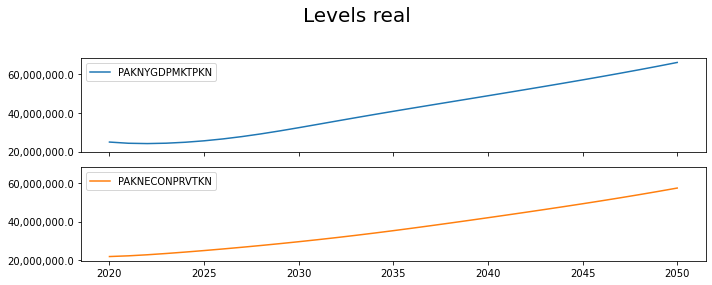

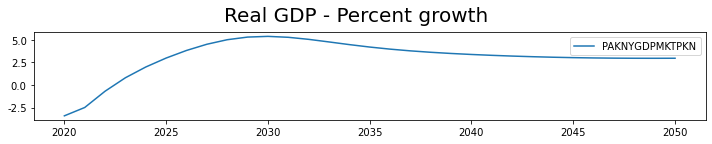

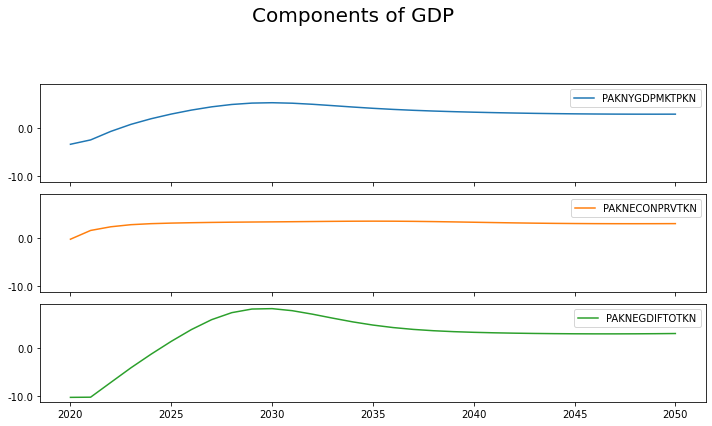

In [24]:
mpak.smpl(2020,2050)
import pandas as pd
pd.options.display.float_format = '{:.1f}'.format
_ = mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].plot(kind='line',title='Levels real',colrow=1,top=0.8)
_ = mpak['PAKNYGDPMKTPKN'].pct.mul100.plot(kind='line',title='Real GDP - Percent growth',colrow=1,top=0.8)
_ = mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN PAKNEGDIFTOTKN'].pct.mul100.plot(kind='line',title='Components of GDP ',colrow=1,top=0.8) #this uses the values of the baseline



### Shock minus control presentations

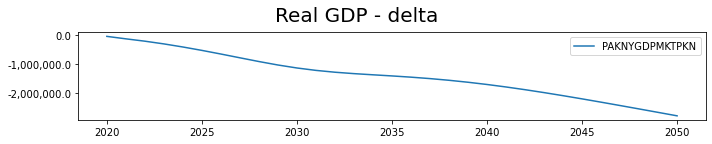

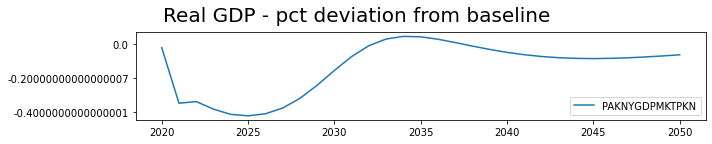

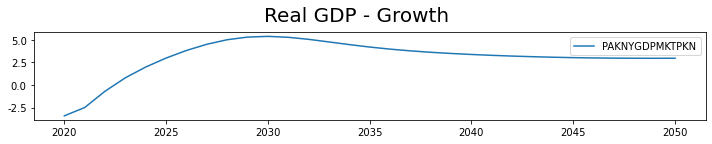

In [25]:
pd.options.display.float_format = '{:.1f}'.format
_ = mpak['PAKNYGDPMKTPKN'].dif.plot(kind='line',title='Real GDP - delta',colrow=1,top=0.8)
_ = mpak['PAKNYGDPMKTPKN'].difpct.mul100.plot(kind='line',title='Real GDP - pct deviation from baseline',colrow=1,top=0.8)
_ = mpak['PAKNYGDPMKTPKN'].pct.mul100.plot(kind='line',title='Real GDP - Growth',colrow=1,top=0.8) #this uses the values of the baseline



### Plot shock side by side control

The plot_alt method allows you to compare the levels or growth rates of a variable across the most ercent and baseline scenarios.

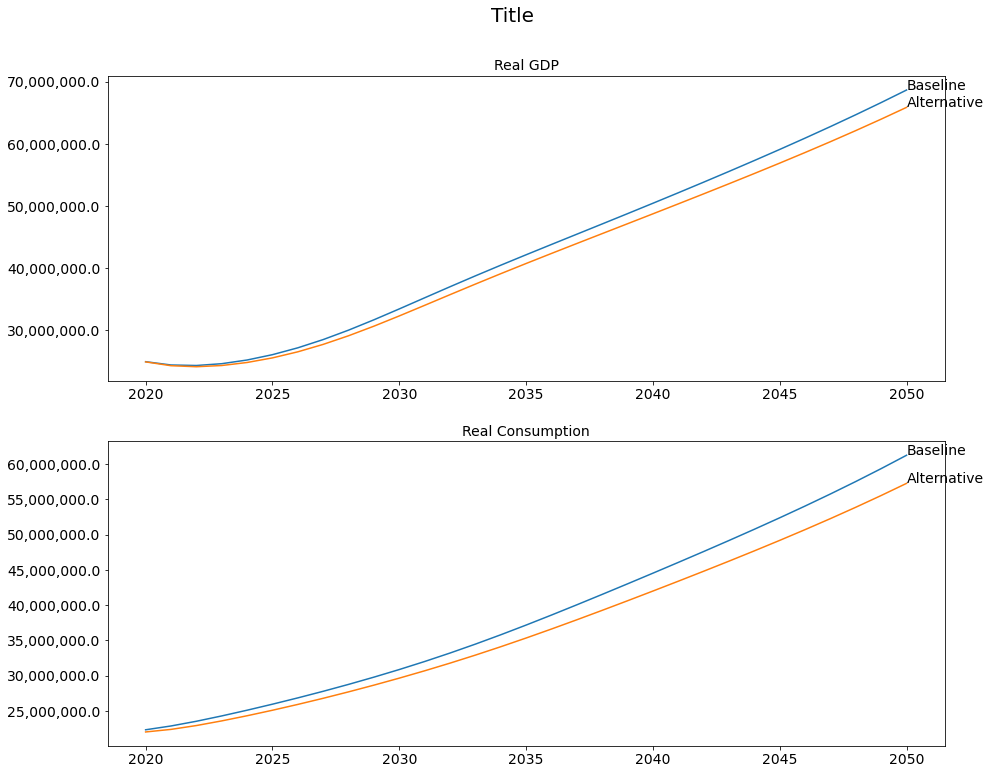

In [26]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].plot_alt() ;

In [27]:
#mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].plot_alt().pct ; does nt work.

## Plot multiple series from different scenarios

This is straight python

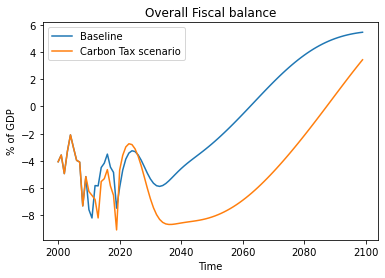

In [28]:
import matplotlib.pyplot as plt

base = mpak.basedf
alt = mpak.lastdf
plt.plot(mpak.basedf.loc[2000:2099,'PAKGGBALOVRLCN']/mpak.basedf.loc[2000:2099,'PAKNYGDPMKTPCN']*100,label='Baseline')
plt.plot(mpak.lastdf.loc[2000:2099,'PAKGGBALOVRLCN_'],label='Carbon Tax scenario')
  
# set y label
plt.ylabel('% of GDP')
  
# set x label
plt.xlabel('Time')
plt.legend()  
# set title
plt.title('Overall Fiscal balance')
  
# display plot
plt.show()




### Plot four separate plots of multiple series in grid

C:\Users\ibhan\AppData\Local\Temp/ipykernel_18360/4266983907.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


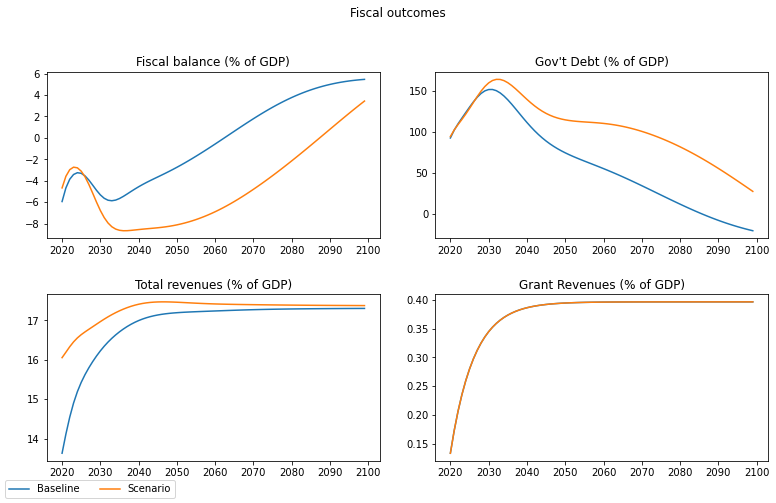

In [29]:
figure,axs= plt.subplots(2,2,figsize=(11, 7))
axs[0,0].plot(mpak.basedf.loc[2020:2099,'PAKGGBALOVRLCN_'],label='Baseline')
axs[0,0].plot(mpak.lastdf.loc[2020:2099,'PAKGGBALOVRLCN_'],label='Scenario')
#axs[0,0].legend()

axs[0,1].plot(mpak.basedf.loc[2020:2099,'PAKGGDBTTOTLCN_'],label='Baseline')
axs[0,1].plot(mpak.lastdf.loc[2020:2099,'PAKGGDBTTOTLCN_'],label='Scenario')

axs[1,0].plot(mpak.basedf.loc[2020:2099,'PAKGGREVTOTLCN']/mpak.basedf.loc[2020:2099,'PAKNYGDPMKTPCN']*100,label='Baseline')
axs[1,0].plot(mpak.lastdf.loc[2020:2099,'PAKGGREVTOTLCN']/mpak.lastdf.loc[2020:2099,'PAKNYGDPMKTPCN']*100,label='Scenario')

axs[1,1].plot(mpak.basedf.loc[2020:2099,'PAKGGREVGRNTCN']/mpak.basedf.loc[2020:2099,'PAKNYGDPMKTPCN']*100,label='Baseline')
axs[1,1].plot(mpak.lastdf.loc[2020:2099,'PAKGGREVGRNTCN']/mpak.lastdf.loc[2020:2099,'PAKNYGDPMKTPCN']*100,label='Scenario')
#axs2[4].plot(mpak.lastdf.loc[2000:2099,'PAKGGREVGRNTCN']/mpak.basedf.loc[2000:2099,'PAKNYGDPMKTPCN']*100,label='Scenario')

axs[0,0].title.set_text("Fiscal balance (% of GDP)")
axs[0,1].title.set_text("Gov't Debt (% of GDP)")
axs[1,0].title.set_text("Total revenues (% of GDP)")
axs[1,1].title.set_text("Grant Revenues (% of GDP)")
figure.suptitle("Fiscal outcomes")

plt.figlegend(['Baseline','Scenario'],loc='lower left',ncol=5)  
figure.tight_layout(pad=2.3) #Ensures legend does not overlap dates
figure.show()

# Information about series in model

### Description of mnemonics

In [30]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].des  # descriptions

PAKNYGDPMKTPKN : Real GDP
PAKNECONPRVTKN : Real Consumption


## Extract model formula of specific variables

In [31]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].frml  # formulas

PAKNYGDPMKTPKN : FRML <> PAKNYGDPMKTPKN = PAKNECONPRVTKN+PAKNECONGOVTKN+PAKNEGDIFTOTKN+PAKNEGDISTKBKN+PAKNEEXPGNFSKN-PAKNEIMPGNFSKN+PAKNYGDPDISCKN+PAKDISPREPKN $
PAKNECONPRVTKN : FRML <Z,EXO> PAKNECONPRVTKN =( PAKNECONPRVTKN(-1)*EXP(PAKNECONPRVTKN_A + (-0.2*(LOG(PAKNECONPRVTKN(-1))-LOG((((PAKBXFSTREMTCD(-1)-PAKBMFSTREMTCD(-1))*PAKPANUSATLS(-1))-0.6*(PAKHEAPKN(-1)-PAKHEAPKN(-2))*(1-DURING_1980_2019)+PAKGGEXPTRNSCN(-1)+PAKNYYWBTOTLCN(-1)*(1-PAKGGREVDRCTXN(-1)/100))/((1+PAKGGREVELECER_(-1)/100)*PAKNECONPRVTXN(-1))))+1*((LOG((((PAKBXFSTREMTCD-PAKBMFSTREMTCD)*PAKPANUSATLS)+PAKGGEXPTRNSCN-0.6*(PAKHEAPKN-PAKHEAPKN(-1))*(1-DURING_1980_2019)+PAKNYYWBTOTLCN*(1-PAKGGREVDRCTXN/100))/((1+PAKGGREVELECER_/100)*PAKNECONPRVTXN)))-(LOG((((PAKBXFSTREMTCD(-1)-PAKBMFSTREMTCD(-1))*PAKPANUSATLS(-1))+PAKGGEXPTRNSCN(-1)-0.6*(PAKHEAPKN(-1)-PAKHEAPKN(-2))*(1-DURING_1980_2019(-1))+PAKNYYWBTOTLCN(-1)*(1-PAKGGREVDRCTXN(-1)/100))/((1+PAKGGREVELECER_(-1)/100)*PAKNECONPRVTXN(-1)))))+0.00731351282776-0.141092572478*DUR

## Rename variables
The rename function, replaces the mnemonic with the variables deswcription in whatever output is done subsequently, i.e. in a data dump

In [32]:
mpak.smpl(2020,2025)
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].rename()



       Real GDP  Real Consumption
2020 24900816.5        22023460.6
2021 24284659.6        22388575.9
2022 24120535.0        22932973.5
2023 24316387.3        23592513.7
2024 24802414.7        24321898.1
2025 25543365.8        25102662.4

In [33]:
kept=mpak.keep_solutions #create a dataframe from the model object kept objects
kept.keys() # lists the names of the scenarios



dict_keys(['Baseline', 'Coal, Oil and Gastax : 29 exogenized'])

or a graph

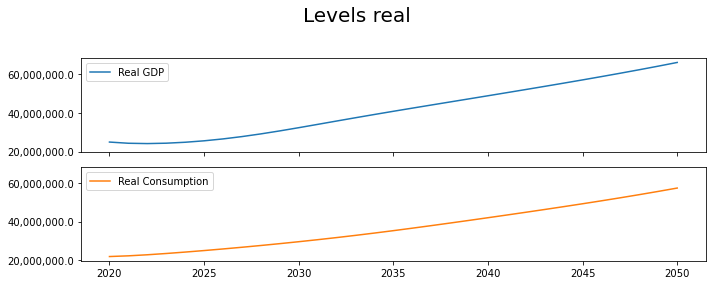

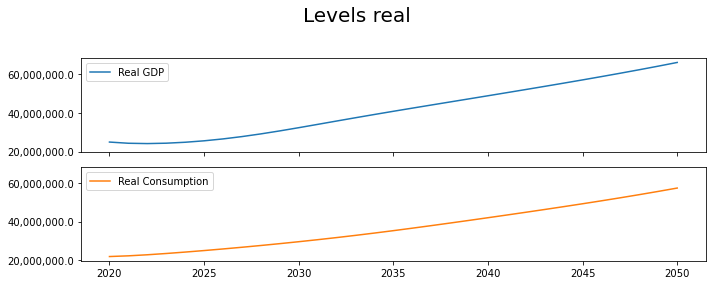

In [34]:
mpak.smpl(2020,2050)
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].rename().plot(kind='line',title='Levels real',colrow=1,top=0.8)

order matters pct must precede rename if you want to do it in combo with pct

    'mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].rename().pct.mul100.plot(kind='line',title='Levels real',colrow=1,top=0.8)'


Does not work, but the below does.

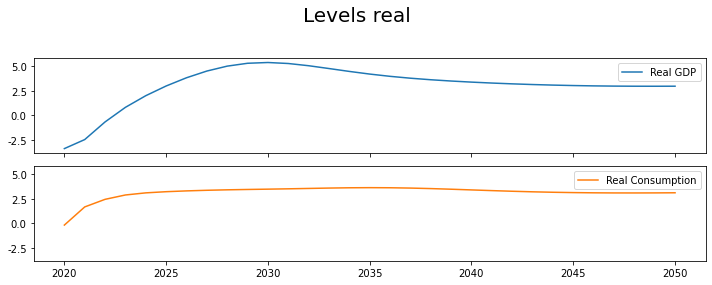

In [35]:
#This works
mpak.smpl(2020,2050)
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].pct.rename().mul100.plot(kind='line',title='Levels real',colrow=1,top=0.8);

In [36]:
### Graphs showing multiple lines on one gapgh
#### 

## Relationships (dependencies) between variables

ModelFlow perform a number of analytical chores, that it can oresent graphically or in tabular form.

These inlude presenting the relationships between variables.  In this case, we are displaying all of the vairables that depend directly upon GDP and consumption and those that are determined by them.  Directly because in this example we are only going one step up and backward inthe formulae.

The thicker  arrow the more dependent the variable is on the other, ie, it is related to the cobntribution that the variable made to the value of the other.

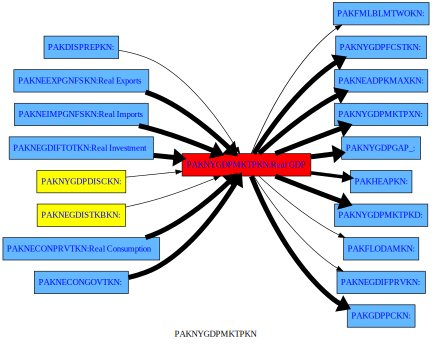

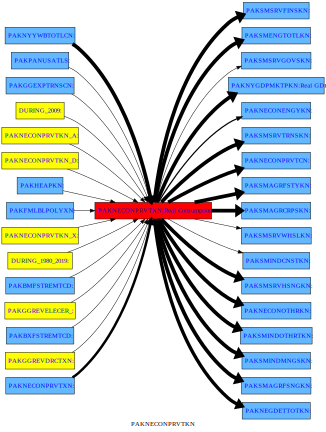

In [37]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].draw(up=1,down=1)  # diagram all direct dependencies 

Relationships graphs can be customized, for instance by including only variables that impact or are impacted by 20% or more or increasing how far up or down the chain one goes.

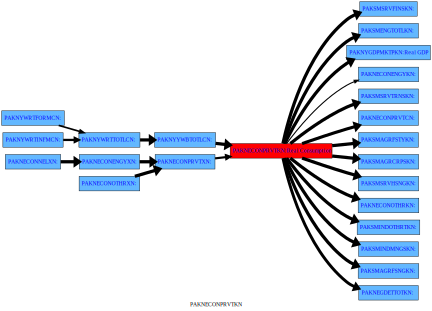

In [38]:
mpak['PAKNECONPRVTKN'].draw(up=3,down=1,filter=20)  # diagram  direct dependencies that explain at least 20% of the dependent variable or are explained 20% or more by the depenednt varable

## Contributions of variables to the changes observed.

The dekomp command decomposes the contributions of right hand side variables to the observed change in the left hand side variables.

In the below example, which is servied from our simulation imposing a carbon tax, the change in consumption demand had a large impact on GDP 280% of the total in 2923 (third set of results), while government consumotionc ontribnuted 24% and investment 16 percent.

Imports had a strong negative contribution -227 as much of the cinrease in consumption, investment and government demand was imported. 


In [39]:
#This does ot seem to work for some reason at he moment
#with mpak.set_smpl(2021,2025):
#    mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].dekomp()  # frml attribution 
mpak.dekomp.cache_clear(); # will not be needed when upgrade beyond current cersion of modelflow   
#but this does.    
mpak.smpl(2021,2025)
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].dekomp()  # frml attribution     
    



Formula        : FRML <> PAKNYGDPMKTPKN = PAKNECONPRVTKN+PAKNECONGOVTKN+PAKNEGDIFTOTKN+PAKNEGDISTKBKN+PAKNEEXPGNFSKN-PAKNEIMPGNFSKN+PAKNYGDPDISCKN+PAKDISPREPKN $ 

                           2021            2022            2023            2024            2025
Variable    lag                                                                                
Base        0   24401343.463925 24318637.823282 24608924.663577 25202295.733179 26061308.807425
Alternative 0   24284659.609729 24120534.950791 24316387.309271 24802414.676811 25543365.787820
Difference  0    -116683.854196  -198102.872491  -292537.354307  -399881.056368  -517943.019605
Percent     0         -0.478186       -0.814613       -1.188745       -1.586685       -1.987402

 Contributions to differende for  PAKNYGDPMKTPKN
                             2021           2022           2023           2024           2025
Variable       lag                                                                           
PAKNECONPRVTKN 0   -4

# Output
## Line plots

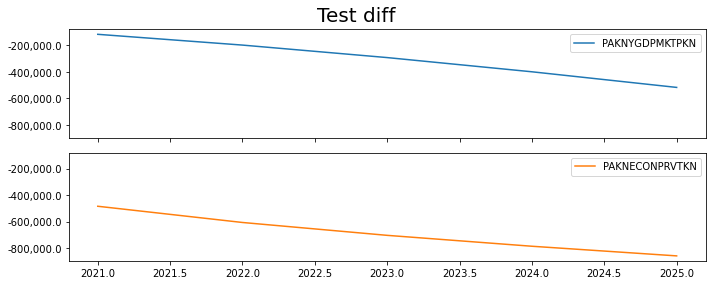

In [40]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].dif.plot(colrow=1,title='Test diff');  # difference in growth  lastdf and basedf 

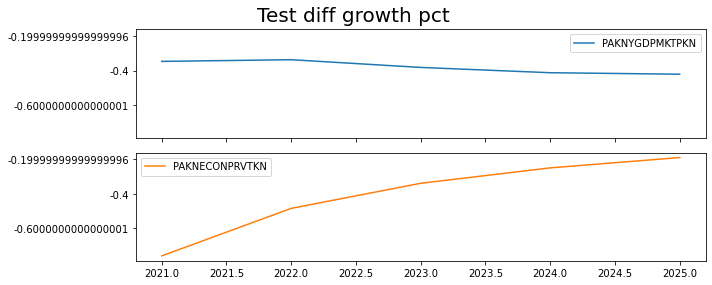

In [41]:

mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].difpct.mul100.plot(colrow=1,title='Test diff growth pct ');  
# difference in growth  lastdf and basedf 
# mul100 multiplies the results by 100 

## Heatmaps

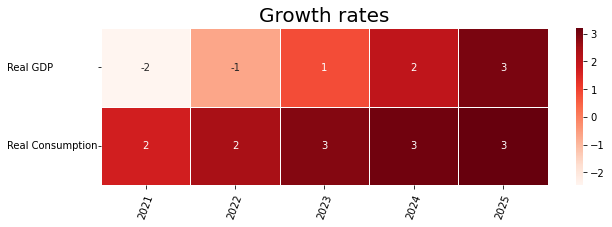

In [42]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].pct.rename().mul100.heat(title='Growth rates',annot=True,dec=0,size=(10,3));  
# growth lastdf and basedf
# rename() uses the description
# mul100 multiplies by 100
#annot ,dec affect the annotations (numbers in cells)

## Violin, swarm and boxplots, 
Not obvious for macro models, but useful for bank models with many banks. 

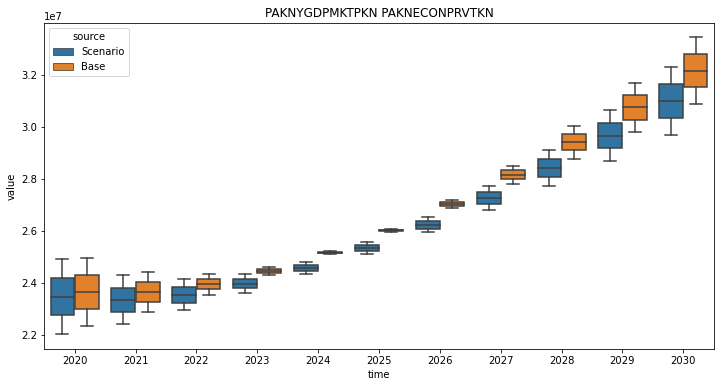

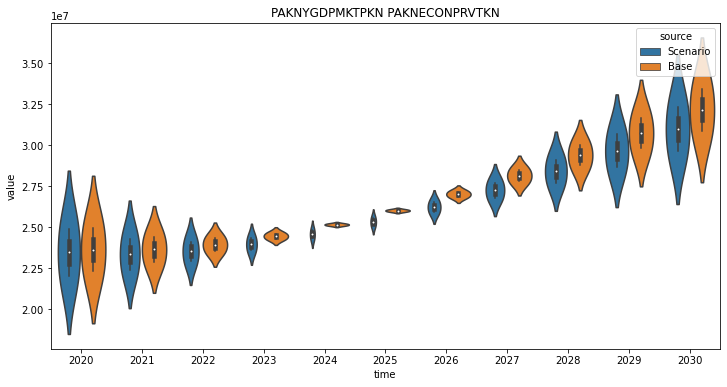

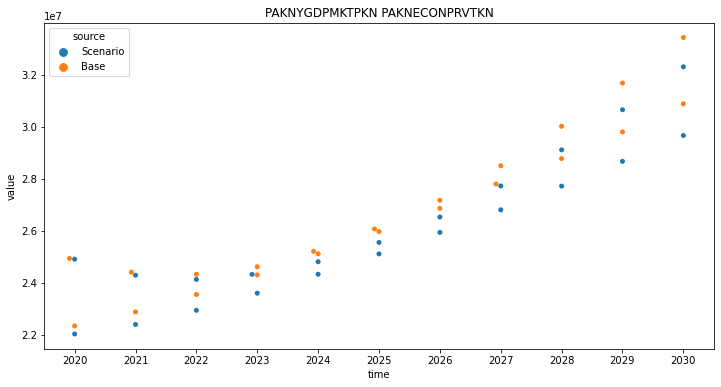

In [43]:
with mpak.set_smpl(2020,2030): 
    mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].difpct.box()  
    mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].difpct.violin()  
    mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].difpct.swarm()  

## Plot baseline vs alternative
A raw routine, only showing levels.
To make it useful it should be replaced. 

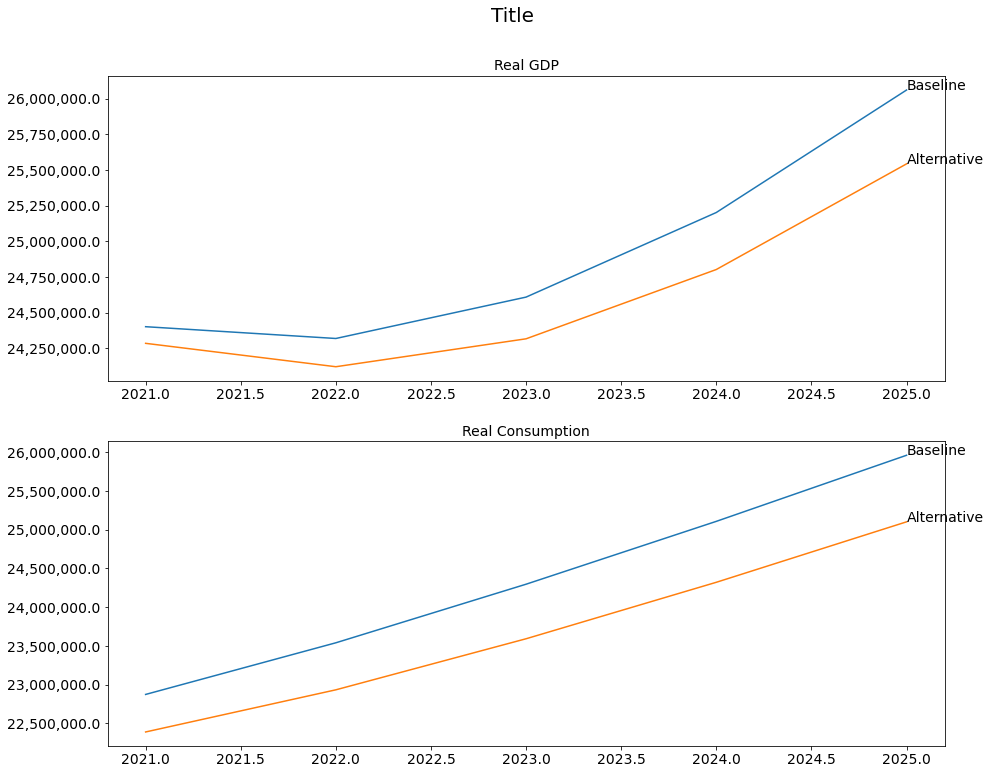

In [44]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].plot_alt() ;


In [45]:
df['Cons-Base']=mpak.basedf.PAKNECONPRVTKN
df['Cons-scenario']=mpak.lastdf['pakneconprvtkn']
df['Cons-Base Cons-scenario'].plot()

NameError: name 'df' is not defined